In [232]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor

from torchvision import transforms, datasets
import torchvision.transforms.functional as fn
import torchvision.transforms
from PIL import Image


tensor([[[0.4235, 0.4510, 0.4000,  ..., 0.0353, 0.0039, 0.0000],
         [0.4039, 0.4118, 0.3804,  ..., 0.0118, 0.0039, 0.0039],
         [0.4353, 0.4196, 0.4039,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.1059, 0.1176, 0.1294,  ..., 0.2902, 0.2863, 0.2824],
         [0.0863, 0.0941, 0.1137,  ..., 0.3098, 0.3137, 0.3137],
         [0.0941, 0.0863, 0.1020,  ..., 0.2980, 0.3137, 0.3176]],

        [[0.4980, 0.5255, 0.4706,  ..., 0.0431, 0.0118, 0.0039],
         [0.4745, 0.4824, 0.4510,  ..., 0.0196, 0.0118, 0.0118],
         [0.4980, 0.4824, 0.4745,  ..., 0.0078, 0.0039, 0.0039],
         ...,
         [0.1647, 0.1765, 0.1882,  ..., 0.2784, 0.2745, 0.2706],
         [0.1333, 0.1412, 0.1647,  ..., 0.2902, 0.2941, 0.2941],
         [0.1412, 0.1333, 0.1529,  ..., 0.2784, 0.2863, 0.2902]],

        [[0.3216, 0.3490, 0.3059,  ..., 0.0235, 0.0078, 0.0000],
         [0.3098, 0.3176, 0.2863,  ..., 0.0000, 0.0000, 0.0000],
         [0.3451, 0.3294, 0.3176,  ..., 0.0000, 0.0000, 0.

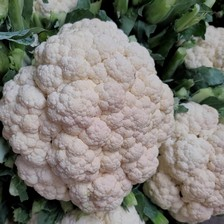

In [233]:
img = Image.open("data/Vegetable Images/train/Cauliflower/0001.jpg")
img_tensor = fn.to_tensor(img)
print(img_tensor)
print(f"Mean: {img_tensor.mean()}\nStd: {img_tensor.std()}")
img


In [234]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

In [235]:
train_transform = transforms.Compose([transforms.RandomRotation(30),
                                      transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5], 
                                                            [0.5, 0.5, 0.5])])

In [236]:
dataset = datasets.ImageFolder('data/Vegetable Images/train', transform=train_transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)


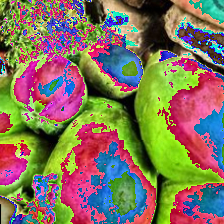

In [237]:
images, labels = next(iter(dataloader))
fn.to_pil_image(images[0])

In [238]:
print(labels)

tensor([10, 13,  0,  2,  8, 14,  5, 13,  4, 13, 14, 14, 11,  7, 14,  8, 14, 13,
         8,  9, 13,  0,  4, 13, 14,  6, 13, 12, 10,  1,  7, 11])


In [239]:
class VegetableClassifier(nn.Module):
    def __init__(self, out_size=15) -> None:
        super(VegetableClassifier, self).__init__()
        self.linear_out_size = out_size
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.network = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size= (7,7), stride=(2,2), padding=(3,3), bias=False), #maybe add bias?
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),

            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(64),
        )
        self.avg_maxpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.linear_classifier = nn.Linear(in_features=64, out_features=self.linear_out_size)
        
    def forward(self, input):
        input = torch.unsqueeze(input, 0)
        input = self.network(input)
        input = self.avg_maxpool(input)
        input = torch.flatten(input, 1)
        return self.linear_classifier(input)
    
    def fit(self, num_epochs, loss_fn, optimizer, dataloader):
        for epoch in range(num_epochs):
            best_loss = 200000
            for images, labels in dataloader:
                images = images.to(self.device)
                labels = labels.to(self.device)
                for i in range(len(images)):
                    optimizer.zero_grad()
                    pred = self.forward(images[i])
                    loss = loss_fn(pred, labels[i])
                    loss.backward()
                    optimizer.step()
                #optimizer.zero_grad()
                #pred = self.forward(images)
                #loss = loss_fn(pred, labels)
                #loss.backward()
                #optimizer.step()

                best_loss = loss if loss < best_loss else best_loss
            print(f"Epoch {epoch}: best_loss: {best_loss}")

                

In [240]:
train_transform = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.5, 0.5, 0.5], 
        [0.5, 0.5, 0.5]
    ),
])

In [241]:
dataset = datasets.ImageFolder('data/Vegetable Images/train', transform=train_transform) # temp changed to test
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

In [242]:
model = VegetableClassifier()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.99))
loss_fn = nn.CrossEntropyLoss()

In [243]:
images, labels = next(iter(dataloader))
model.forward(images[0])

tensor([[-0.0388,  0.0887,  0.0841, -0.0982,  0.0471, -0.0392, -0.0966, -0.0308,
          0.0958, -0.0422,  0.0432,  0.1063, -0.1044, -0.1124,  0.0194]],
       grad_fn=<AddmmBackward0>)

In [244]:
model.train()
model.fit(num_epochs=20, loss_fn=loss_fn, optimizer=optimizer, dataloader=dataloader)

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same